In [32]:
import pandas as pd
import requests as rq
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
import random
import numpy as np
import h5py
import os
from __future__ import print_function
from shapely import geometry
import fiona
import ipyparallel as ipp
import geopandas as gpd
from geopandas.geoseries import *
from geopandas.tools import sjoin
import shapefile
from shapely.geometry import shape, Point
import pickle

### Directory paths to the placepulse images and the augmentation data

In [183]:
imgDir = "/work/sagarj/Work/BellLabs/streetview/PPImages/"
AugDir = "/work/sagarj/Work/BellLabs/streetview/AugImages/"

### Load placepulse vote data

In [34]:
df = pd.read_csv("../streetview/votes.csv")

In [35]:
len(df['right_id'].unique())

111383

### Shape file for localizing datasets

In [36]:
londonShp = "../shapeFiles/London_Ward_CityMerged.shp"
USAUAShp = "../shapeFiles/cb_2016_us_ua10_500k.shp"

In [37]:
df.keys()

Index([u'left_id', u'right_id', u'winner', u'left_lat', u'left_long',
       u'right_lat', u'right_long', u'category'],
      dtype='object')

In [38]:
df.head()

,left_id,right_id,winner,left_lat,left_long,right_lat,right_long,category
0,513d2dbefdc9f03587002515,51413b2ffdc9f049260058ca,left,41.935385,-87.696485,34.047847,-118.236107,wealthy
1,513d7e23fdc9f0358700733a,513d7ac3fdc9f0358700693f,equal,40.744156,-73.935579,-33.526384,-70.591309,depressing
2,50f60c4dbeb2fed91000028d,513cb652fdc9f03587000a1e,right,45.505837,-122.583705,29.752872,-95.298844,depressing
3,513d9ff9fdc9f0358700887c,513cd544fdc9f03587001efc,left,33.747093,-84.289843,-33.930831,18.406321,depressing
4,513f320cfdc9f0358700e030,513cc3acfdc9f035870016c3,left,52.551685,13.416548,29.763818,-95.394621,safety


In [39]:
len(df['right_id'].unique())

111383

### check if a lat long falls in the shapefile polygon

In [40]:
def check(point, polygon):
    if any(polygon.contains(point)):
        return True
    else:
        return False

def checkPoly(point,polygonArray):
    truths = [check(point , poly) for poly in polygonArray]
    return any(truths)

### Create a dictionary of localized data

In [41]:
geometryDict = {}
for idx, row in df.iterrows():
    if row['left_id'] not in geometryDict:
        p = Point(row['left_long'] , row['left_lat'])
        geometryDict[row['left_id']] = p
    if row['right_id'] not in geometryDict:
        p = Point(row['right_long'] , row['right_lat'])
        geometryDict[row['right_id']] = p

In [42]:
geometryDict.keys()[1]

'51409449fdc9f04926000870'

In [43]:
# with open("../Data/AllStreetScoreImageLocs.pkl" , 'w') as f:
#     pickle.dump(geometryDict,f,protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
geometryDict[geometryDict.keys()[2]].x

13.473838

In [45]:
usa = gpd.read_file("../shapeFiles/cb_2016_us_ua10_500k.shp")

In [46]:
# london = gpd.read_file("../shapeFiles/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp")

In [47]:
usa.head()

,AFFGEOID10,ALAND10,AWATER10,GEOID10,LSAD10,NAME10,UACE10,UATYP10,geometry
0,400C100US04087,5204595,0,04087,76,"Auburn, NE",04087,C,"POLYGON ((-95.857736 40.392806, -95.853053 40...."
1,400C100US86653,41537873,0,86653,76,"Taos, NM",86653,C,"(POLYGON ((-105.57698 36.363231, -105.574978 3..."
2,400C100US70156,67103610,948468,70156,76,"Plattsburgh, NY",70156,C,"(POLYGON ((-73.443826 44.737779, -73.442940999..."
3,400C100US35515,4536217,35372,35515,76,"Greenwich, NY",35515,C,"POLYGON ((-73.538184 43.092688, -73.528066 43...."
4,400C100US41779,4457305,0,41779,76,"Irrigon, OR",41779,C,"POLYGON ((-119.531836 45.899186, -119.505269 4..."


In [48]:
# pd.set_option('display.max_rows', len(usa['NAME10']))
# print(usa['NAME10'])
# pd.reset_option('display.max_rows')

In [49]:
# us_selected_poly = ['Washington, DC--VA--MD' , 'New York--Newark, NY--NJ--CT' , 'Boston, MA--NH--RI' , 'Seattle, WA' , 'Portland, OR--WA' , 
#                     'Denver--Aurora, CO' , 'San Diego, CA' , 'San Francisco--Oakland, CA']
#us_selected_poly = ['Washington, DC--VA--MD' , 'New York--Newark, NY--NJ--CT' , 'Boston, MA--NH--RI']
us_selected_poly = ['Boston, MA--NH--RI']
# london_selected_poly = ['Kensington and Chelsea','Westminster','Lambeth','Southwark','Hammersmith and Fulham','City of London','Islington','Camden']

In [50]:
# london_poly = [london[(london['NAME'] == k)]['geometry'] for k in london_selected_poly]

### Select specific images from polygons

In [51]:
us_poly = [usa[(usa['NAME10'] == k)]['geometry'] for k in us_selected_poly]

In [52]:
print(us_poly)

[1283    (POLYGON ((-70.861812 42.658277, -70.860432 42...
Name: geometry, dtype: object]


In [53]:
checkPoly(geometryDict[geometryDict.keys()[1]] , us_poly )

False

In [54]:
us_poly_Ids = [k for k in geometryDict if checkPoly(geometryDict[k],us_poly)]

In [55]:
# london_poly_Ids = [k for k in geometryDict if checkPoly(geometryDict[k],london_poly)]

In [56]:
len(us_poly_Ids)# ,len(london_poly_Ids)

1332

In [57]:
us_poly_Ids[1]

'513d6af1fdc9f03587004bcf'

### group images by category as we plan to analyse based on dimension of the image

In [58]:
grouped = df.groupby('category')

In [59]:
categoryPosts = {}
for k in grouped.groups.keys():
    categoryPosts[k] = grouped.get_group(k)

In [60]:
categoryPosts.keys()

['beautiful', 'boring', 'depressing', 'safety', 'lively', 'wealthy']

In [61]:
DimensionDF = categoryPosts['beautiful']

In [62]:
len(DimensionDF)

175361

In [63]:
numbers = DimensionDF.groupby(['left_id'])

In [64]:
VotesDistribution = numbers.size()

### Use truse skill to convert images from a particular dimension to an ordinal scale 

In [65]:
from trueskill import Rating , rate_1vs1 , rate
def trueSkillRate(df):
    skills = {}
    ratingTable = []
    for index, row in df.iterrows():
        if row['left_id'] not in skills:
            skills[row['left_id']] = Rating()
        if row['right_id'] not in skills:
            skills[row['right_id']] = Rating()
            
        if row['winner'] == 'left':
            nRLeft , nRRight = rate_1vs1(skills[row['left_id']] , skills[row['right_id']] )
            skills[row['left_id']] = nRLeft
            skills[row['right_id']] = nRRight
            touple = {row['left_id']:nRLeft , row['right_id'] : nRRight}
            ratingTable.append(touple)
        elif row['winner'] == 'right':
            nRRight , nRLeft = rate_1vs1(skills[row['right_id']] , skills[row['left_id']] )
            skills[row['left_id']] = nRLeft
            skills[row['right_id']] = nRRight
            touple = {row['left_id']:nRLeft , row['right_id'] : nRRight}
            ratingTable.append(touple)
        else:
            nRRight , nRLeft = rate_1vs1(skills[row['right_id']] , skills[row['left_id']] , drawn = True )
            skills[row['left_id']] = nRLeft
            skills[row['right_id']] = nRRight
            touple = {row['left_id']:nRLeft , row['right_id'] : nRRight}
            ratingTable.append(touple)
    
    return skills , ratingTable

### Code to do stability analysis of the trueskill rating (can be used for other methods) to see how many samples change ordinal ratings as you consider more and more competetions

In [66]:
def stabilityAnalysis(df , start , end):
    classflips = []
    rootflips = []
    numbers = DimensionDF.groupby('left_id')
    TargetDf = numbers.filter(lambda x: len(x) > start)
    depressingSkills , _ = trueSkillRate(TargetDf)
    root1 = [k for k in depressingSkills if depressingSkills[k].mu > 25]
    root2 = [k for k in depressingSkills if depressingSkills[k].mu < 25]

    for i in range(start,end+1):
        
        TargetDf = numbers.filter(lambda x: len(x) > i)
        depressingSkills , _ = trueSkillRate(TargetDf)
        r1 = [k for k in depressingSkills if depressingSkills[k].mu > 25]
        r2 = [k for k in depressingSkills if depressingSkills[k].mu < 25]
        
        TargetDf = numbers.filter(lambda x: len(x) > i+1) 
        depressingSkills , _ = trueSkillRate(TargetDf)
        class1 = [k for k in depressingSkills if depressingSkills[k].mu > 25]
        class2 = [k for k in depressingSkills if depressingSkills[k].mu < 25]
        
        
        flips_root = len(set(root1).intersection(class2)) + len(set(root2).intersection(class1))
        flips_consecutive = len(set(r1).intersection(class2)) + len(set(r2).intersection(class1))
        print ("Total class flips at threshold level %d from %d : %d , %d from root" %(i,i+1,flips_consecutive , flips_root ))
        rootflips.append(flips_root)
        classflips.append(flips_consecutive)

    return classflips , rootflips
        

In [67]:
from math import sin, cos, sqrt, atan2, radians
def linearDist( point1 , point2 ):
    #radius of earth in meters
    R=6378.137
    #Coordinate offsets in radians
    lat1 = radians(point1.y)
    lon1 = radians(point1.x)
    lat2 = radians(point2.y)
    lon2 = radians(point2.x)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    absDist = R * c
#     if absDist/10.0 < 1:
#         distance = 10
#     elif absDist/100.0 < 1:
#         distance = 100
#     elif absDist/500.0 < 1:
#         distance = 500
#     elif absDist/1000.0 < 1:
#         distance = 1000
#     else:
#         distance = 5000
        
    return absDist
 

In [68]:
# rollingFlips, rootFlips  = stabilityAnalysis(DimensionDF, 3 , 11)

In [69]:
# _, ax1 = plt.subplots(figsize=(15, 10))
# ax1.plot(range(4,13), rollingFlips  , 'b' )
# ax1.plot(range(4,13) , rootFlips  , 'g')

# ax1.set_xlabel('Votes Threshold', fontsize = 20)
# ax1.set_ylabel('Samples that switch classes' , fontsize = 20)
# plt.title("Trueskill Stability" , fontsize = 20)
# ax1.legend(["Flips compared to last threshold" , "Flips compared to threshold of 4 votes"])




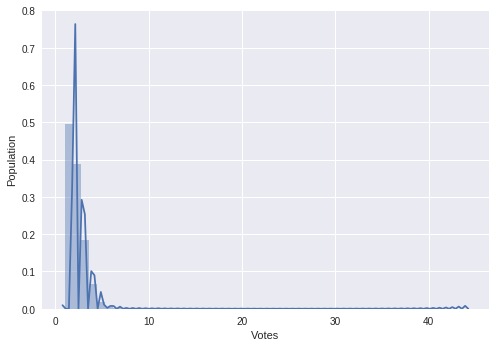

In [70]:
sns.set(rc={"figure.figsize": (16, 12)})
sns.set(font_scale=1)  
ax = sns.distplot(VotesDistribution )
ax.set(xlabel='Votes', ylabel='Population')


### Find the final Dataframe that we use for rankings

In [197]:
TargetDf = numbers.filter(lambda x: len(x) >= 4) 

In [198]:
len(TargetDf['left_id'].unique())

7341

In [199]:
usa_df = TargetDf[(TargetDf['left_id'].isin(us_poly_Ids))]

In [200]:
len(usa_df)

395

In [201]:
len(list(set(usa_df['left_id'])))

88

In [202]:
# usa_df.to_csv("../streetview/BostonVotes.csv")

In [203]:
# fivevotes = pd.read_csv("../streetview/5votes.csv")
# len(fivevotes)

In [204]:
len(list(set(TargetDf['left_id'])))

7341

In [205]:
len(TargetDf)

32531

In [206]:
len(TargetDf[(TargetDf['winner'] == 'equal')])

3016

In [207]:
from trueskill import Rating

In [208]:
from trueskill.backends import available_backends
from trueskill import setup
from mpmath import mp
if 'mpmath' in available_backends():
    # mpmath can be used in the current environment
    setup(backend='mpmath')
mp.dps = 32

In [209]:
depressingSkills , depRatingTable = trueSkillRate(TargetDf)

In [210]:
geometryDict[us_poly_Ids[1]].xy[0][0]

-71.09660699999999

In [211]:
#Filter the final ratings based on the US city ids of images
finalSkills = {}
leftids = list(set(TargetDf['left_id']))
#uncomment below line to limit data to US cities
# leftids = us_poly_Ids
for k in depressingSkills:
    if k in leftids:
        finalSkills[k] = {}
        finalSkills[k]['rating'] = depressingSkills[k].mu
        finalSkills[k]['variance'] = depressingSkills[k].sigma
#         finalSkills[k]['lat'] = geometryDict[k].xy[1][0]
#         finalSkills[k]['long'] = geometryDict[k].xy[0][0]

In [212]:
len(set(finalSkills.keys()))

7341

In [213]:
skillMeans = [finalSkills[k]['rating'] for k in finalSkills]

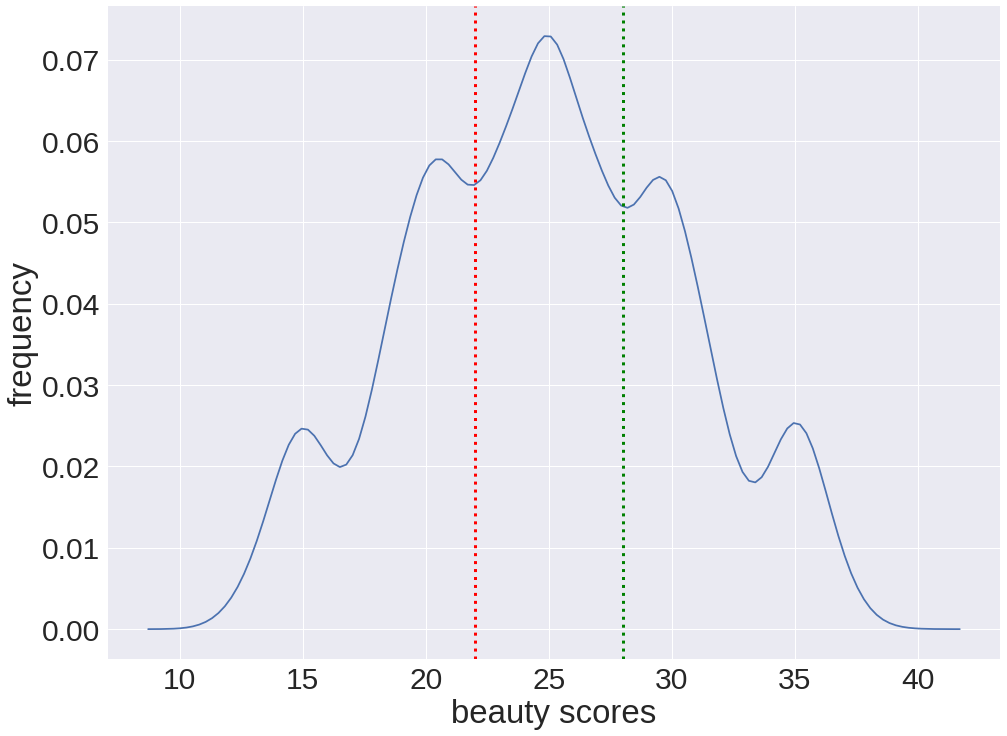

In [217]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=3) 
ax = sns.distplot(skillMeans , hist=False, kde_kws=dict(cumulative=False) )
ax.axvline(x=22, ymin=0, ymax=1, linewidth=3, color = 'r', linestyle='dotted')
ax.axvline(x=28, ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt
ax.set(xlabel='beauty scores', ylabel='frequency')

In [218]:
# with open("bostonImages.json",'wb') as f:
#     json.dump(finalSkills,f)

In [219]:
from itertools import combinations
def doSampleTesting(skills , sampleSize, iters , distThresh):
    median = []
    variance = []
    for i in range(iters):
        sample = random.sample(skills.keys(),sampleSize)
        deltaRating = []
        for combo in combinations(sample, 2):
            dist = linearDist(geometryDict[combo[0]] , geometryDict[combo[1]])
            if dist < distThresh:
                deltaRating.append(abs(skills[combo[0]]['rating'].mu - skills[combo[1]]['rating'].mu))
        median.append(np.median(deltaRating))
        variance.append(np.var(deltaRating))
    return median , variance

In [220]:
# sample = random.sample(finalSkills.keys(),300)

In [221]:
# from itertools import combinations

# distances = []
# deltaRating = []
# # c= ipp.Client()
# for combo in combinations(sample, 2):
#     #d = c[0].apply_async(linearDist , geometryDict[combo[0]] , geometryDict[combo[1]])
#     dist = linearDist(geometryDict[combo[0]] , geometryDict[combo[1]])
#     if dist < 10:
#         distances.append(dist)
#         #delta = c[1].apply_async(abs ,(finalSkills[combo[0]]['rating'].mu - finalSkills[combo[1]]['rating'].mu))
#         deltaRating.append(abs(finalSkills[combo[0]]['rating'].mu - finalSkills[combo[1]]['rating'].mu))
    
#     #distances.append(d)
#     #deltaRating.append(delta)

In [222]:
# deltaMedians , deltaVar = doSampleTesting(finalSkills , 300 , 100 , 10)

In [223]:
# len(deltaMedians)

In [224]:
#g = sns.jointplot(np.asarray(distances), np.asarray(deltaRating), kind="reg")
# ax = sns.distplot(deltaMedians)
# ax = sns.distplot(deltaVar)


In [225]:
len(list(set(finalSkills.keys())))

7341

In [226]:
depRatingTable[1]

{'50f4455ffdc9f065f000344c': trueskill.Rating(mu=29.396, sigma=7.171),
 '50f5eab3fdc9f065f0007c7a': trueskill.Rating(mu=20.604, sigma=7.171)}

In [227]:
# rated_depSkills = rate(depRatingTable)

In [228]:
# skill = {}
# for s in rated_depSkills:
#     for k in s:
#         if k in skill:
#             skill[k].append(s[k])
#         else:
#             skill[k] = []
#             skill[k].append(s[k])

In [229]:
#Sorted by plain pairvise matches
sortedImagesSkillsMu = sorted(finalSkills, key=lambda k: finalSkills[k]['rating'])
sortedImagesSkillsSigma = sorted(finalSkills, key=lambda k: finalSkills[k]['variance'])

In [230]:
finalSkills[sortedImagesSkillsMu[-1]]['rating']

38.72675236400188

In [231]:
#Sorted by ranking tables
# sortedImages =  sorted(skill, key=lambda k: skill[k][-1].mu)

In [232]:
# sortedImagesByVar =  sorted(skill, key=lambda k: skill[k][-1].sigma)

In [233]:
# skill[sortedImages[-1]][0].mu

In [234]:
#Sorted by ranking tables
# imgid = sortedImages[-500]
# Image(imgDir + imgid + ".jpg")

In [235]:
def getPointMapping(df):
    geometryDict = {}
    for idx, row in df.iterrows():
        if row['left_id'] not in geometryDict:
            geometryDict[row['left_id']] = Point((row['left_lat'] , row['left_long']))
        if row['right_id'] not in geometryDict:
            geometryDict[row['right_id']] = Point((row['right_lat'] , row['right_long']))
    return geometryDict

    

In [236]:
len(sortedImagesSkillsMu)

7341

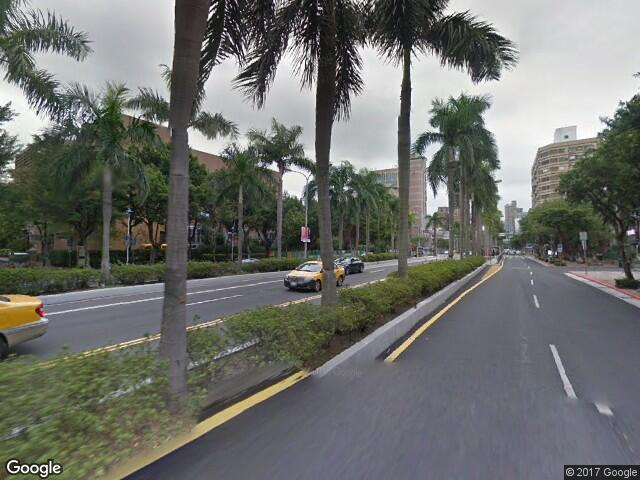

In [241]:
# Sorted by plain pairvise matches
imgid = sortedImagesSkillsMu[-2]
Image(imgDir + imgid + ".jpg")

In [242]:
finalSkills[finalSkills.keys()[1]]

{'rating': 20.915332766225884, 'variance': 5.3432006069410285}

In [243]:
len(finalSkills)

7341

In [244]:
# with open("../Data/BostonAllImages.pkl" , 'w') as f:
#     pickle.dump(finalSkills,f,protocol=pickle.HIGHEST_PROTOCOL)

In [245]:
# dir(rated_depSkills[1][1])

In [246]:
skillMeans = [finalSkills[k]['rating'] for k in finalSkills]
#skillMeans = [depressingSkills[k].mu for k in depressingSkills]

In [247]:
maxSkill= np.max(skillMeans)

In [248]:
print (maxSkill)

38.72675236400188


In [249]:
skillSigmas = [finalSkills[k]['variance'] for k in finalSkills]

In [250]:
# sigmas = [skill[k][-1].sigma for k in skill]

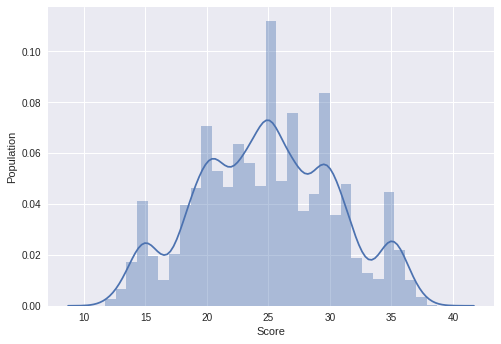

In [251]:
sns.set(rc={"figure.figsize": (16, 12)})
sns.set(font_scale=1) 
# ax = sns.distplot(skillMeans , hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True) )
ax = sns.distplot(skillMeans )
ax.set(xlabel='Score', ylabel='Population')

In [252]:
selectedDf = dict((k, [finalSkills[k]['rating']]) for k in finalSkills if (finalSkills[k]['rating'] < 22 or finalSkills[k]['rating'] > 28))

In [253]:
#selectedDf = dict((k, [depressingSkills[k].mu ]) for k in depressingSkills if (depressingSkills[k].mu < 17 or depressingSkills[k].mu > 32))

In [254]:
len(selectedDf.keys())

4544

In [255]:
testDf = {}
for k in selectedDf:
    path = imgDir + k + ".jpg"
    if selectedDf[k][0] > 28:
        d = {'key':k , 'trueSkill' : selectedDf[k] , 'label' : 1 , 'path' : path}
    elif selectedDf[k][0] < 22:
        d = {'key':k , 'trueSkill' : selectedDf[k] , 'label' : 0 , 'path' : path}
    else:
        continue
    testDf[k] = (k,d)




# fringeDf = {}
# for k in selectedDf:
#     path = imgDir + k + ".jpg"
#     if selectedDf[k][0] <19 :
#         d = {'key':k , 'trueSkill' : selectedDf[k] , 'label' : 0 , 'path' : path}
#     elif selectedDf[k][0] > 33:
#         d = {'key':k , 'trueSkill' : selectedDf[k] , 'label' : 1 , 'path' : path}
#     else:
#         continue
#     fringeDf[k] = dict()
#     fringeDf[k] = d

In [256]:
len(testDf)

4544

In [257]:
testDf[testDf.keys()[1]]

('5140ca1cfdc9f0492600272f',
 {'key': '5140ca1cfdc9f0492600272f',
  'label': 0,
  'path': '/work/sagarj/Work/BellLabs/streetview/PPImages/5140ca1cfdc9f0492600272f.jpg',
  'trueSkill': [14.439092542086918]})

In [258]:
sampledFringe = random.sample( testDf.items(), 100 )

In [259]:
sampledFringe[1][1]

('50f55e55fdc9f065f0004c07',
 {'key': '50f55e55fdc9f065f0004c07',
  'label': 1,
  'path': '/work/sagarj/Work/BellLabs/streetview/PPImages/50f55e55fdc9f065f0004c07.jpg',
  'trueSkill': [29.690613585316985]})

In [260]:
# with open('../Data/bostonAllFringe.pkl', 'wb') as handle:
#     pickle.dump(testDf, handle , protocol=pickle.HIGHEST_PROTOCOL)

In [261]:
workingSample = pickle.load(open("../Data/fringeImages.pkl",'rb'))


In [262]:
workingSample[1]

('5140c9f3fdc9f049260026b9',
 {'key': '5140c9f3fdc9f049260026b9',
  'label': 1,
  'path': '/work/sagarj/Work/BellLabs/streetview/PPImages/5140c9f3fdc9f049260026b9.jpg',
  'trueSkill': [14.917022675126862]})

In [263]:
# labels = [sampledFringe[i][1]['label'] for i in range(len(sampledFringe))]
# np.sum(labels)

In [264]:
# with open('../Data/testImagesBoston.pkl', 'wb') as handle:
#     segnetLabels = pickle.dump(sampledFringe, handle , protocol=pickle.HIGHEST_PROTOCOL)

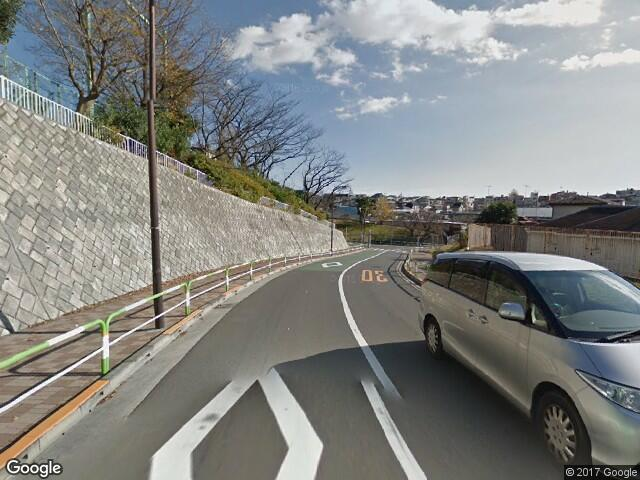

In [266]:
imgid = workingSample[6][1]['key']
#imgid = "51422739fdc9f04926008637"
Image(imgDir + imgid + ".jpg")
#print( selectedDf[selectedDf.keys()[-1]])

In [267]:
len(selectedDf)

4544

In [268]:
filtSkills = dict((k, depressingSkills[k]) for k in depressingSkills if k in us_poly_Ids)

In [269]:
# with open("beautyKeys.txt", "w") as f:
#     for key in depressingSkills:
#         f.write(key+"\n")

In [270]:
filtSkills.keys()[10]

'513d676efdc9f03587004089'

In [271]:
skillsCity = [filtSkills[i].mu for i in filtSkills]

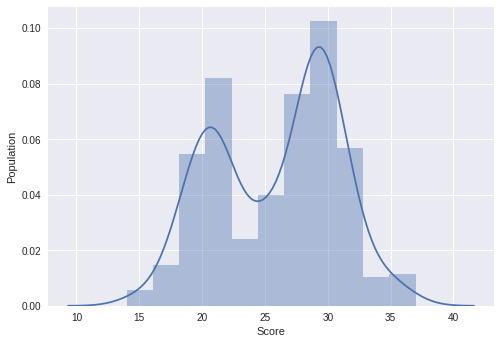

In [272]:
sns.set(rc={"figure.figsize": (16, 12)})
sns.set(font_scale=1) 
# ax = sns.distplot(skillMeans , hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True) )
ax = sns.distplot(skillsCity )
ax.set(xlabel='Score', ylabel='Population')

In [273]:
# sns.distplot(means )

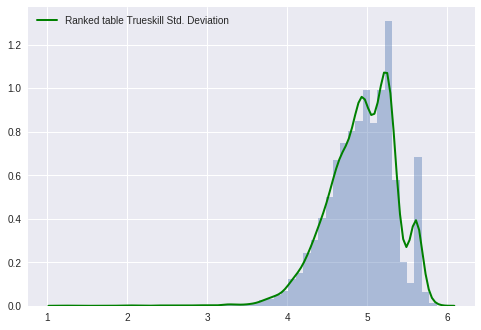

In [274]:
# sns.distplot(sigmas ,kde_kws={"color": "b", "lw": 2, "label": "Paiwise Trueskill Std. Deviation"} )
sns.distplot(skillSigmas , kde_kws={"color": "g", "lw": 2, "label": "Ranked table Trueskill Std. Deviation"},)

In [275]:
# Qdf = numbers.filter(lambda x: len(x) > 0) 

In [276]:
def QscoreRating(df):
    W = {}
    L = {}
    win = {}
    loose = {}
    contest = {}
    rating = {}
    for index, row in df.iterrows():
        if row['left_id'] not in contest:
            contest[row['left_id']] = 0
            
            win[row['left_id']] = {}
            win[row['left_id']]['w'] = 0
            win[row['left_id']]['loosers'] = []
            
            loose[row['left_id']] = {}
            loose[row['left_id']]['l'] = 0 
            loose[row['left_id']]['winners'] = []
            
            W[row['left_id']] =0.0
            L[row['left_id']] =0.0
        
        contest[row['left_id']]+=1
        
        if row['winner'] == 'left':
            win[row['left_id']]['w'] += 1
            win[row['left_id']]['loosers'].append(row['right_id'])

        if row['winner'] == 'right':
            loose[row['left_id']]['l'] += 1
            loose[row['left_id']]['winners'].append(row['right_id'])
        
    for k in win:
        W[k] = float(win[k]['w'])/float(contest[k])
        
    for k in loose:
        L[k] = float(loose[k]['l'])/float(contest[k])
    
    for k in contest:
        S1 = sum([W.get(i,0) for i in win[k]['loosers']])
        S2 = sum([L.get(i,0) for i in loose[k]['winners']])
        if S1 == 0:
            S1 = 0.0
        else:
            S1 = float(S1)/float(win[k]['w'])
        
        if S2 == 0:
            S2 = 0.0
        else:
            S2 = float(S2)/float(loose[k]['l'])
        
        r = (10.0/3.0)*(W[k] + S1 - S2 + 1)
        rating[k] = r
    return rating
            

In [ ]:
# Qscores = QscoreRating(Qdf)

In [ ]:
# len(set(Qdf['left_id']))

In [ ]:
# finalQ = {}
# for index, row in TargetDf.iterrows():
#     finalQ[row['left_id']] = Qscores[row['left_id']]

In [ ]:
# len(finalQ)

In [ ]:
# sns.set(rc={"figure.figsize": (16, 12)})
# sns.distplot(finalQ.values() )
# #sns.distplot(finalQ.values() , hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True) )

In [ ]:
# sortedSimple =  sorted(finalQ, key=lambda k: finalQ[k])

In [ ]:
# len(sortedSimple)

In [ ]:
# imgid = sortedSimple[3500]
# # imgid = "50f43ba4fdc9f065f000326b"
# Image(imgDir + imgid + ".jpg")

In [277]:
import os
import glob
import random
import numpy as np
import pickle

import cv2
import sys
caffe_root = '/work/sagarj/caffe-rc5/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
from caffe.proto import caffe_pb2
import lmdb

#Size of images
IMAGE_WIDTH = 227
IMAGE_HEIGHT = 227

def transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT):

    #Histogram Equalization
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])

    #Image Resizing
    img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)

    return img


def make_datum(img, label):
    #image is numpy.ndarray format. BGR instead of RGB
    return caffe_pb2.Datum(
        channels=3,
        width=IMAGE_WIDTH,
        height=IMAGE_HEIGHT,
        label=label,
        data=np.rollaxis(img, 2).tostring())

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)


In [278]:
testKeys = random.sample(list(selectedDf.keys()), int(0.2*len(selectedDf.keys())))
#testKeys = random.sample(list(depressingSkills.keys()), int(0.2*len(depressingSkills.keys())))
#testKeys = random.sample(list(filtSkills.keys()), int(0.15*len(filtSkills.keys())))


In [279]:
trainKeys = [k for k in selectedDf.keys() if k not in testKeys]
#trainKeys = [k for k in depressingSkills.keys() if k not in testKeys]
#trainKeys = [k for k in filtSkills.keys() if k not in testKeys]

In [280]:
len(set(trainKeys).intersection(testKeys))

0

In [281]:
len(testKeys) , len(trainKeys)

(908, 3636)

In [282]:
import random
train_data = {}
count = 0
for k in trainKeys:
    src = [imgDir + k + ".jpg"]
    if not os.path.exists(src[0]):
        continue
    else:
        if os.path.exists(AugDir + k):
            images = os.listdir(AugDir + k)
            random.shuffle(images)
            for i in images:
                src.append(AugDir + k + "/" + i)
        train_data[k] = src
        count = count + len(src)
        
test_data = {}
for k in testKeys:
    src = [imgDir + k + ".jpg"]
    if not os.path.exists(src[0]):
        continue
    else:
        if os.path.exists(AugDir + k):
            images = os.listdir(AugDir + k)
            random.shuffle(images)
            for i in images:
                src.append(AugDir + k + "/" + i)
        test_data[k] = src
    
    

In [283]:
len(train_data) , len(test_data) , count

(3636, 908, 25452)

In [284]:
train_data

{'5140ca1cfdc9f0492600272f': ['/work/sagarj/Work/BellLabs/streetview/PPImages/5140ca1cfdc9f0492600272f.jpg',
  '/work/sagarj/Work/BellLabs/streetview/AugImages/5140ca1cfdc9f0492600272f/5140ca1cfdc9f0492600272f1.jpg',
  '/work/sagarj/Work/BellLabs/streetview/AugImages/5140ca1cfdc9f0492600272f/5140ca1cfdc9f0492600272f4.jpg',
  '/work/sagarj/Work/BellLabs/streetview/AugImages/5140ca1cfdc9f0492600272f/5140ca1cfdc9f0492600272f0.jpg',
  '/work/sagarj/Work/BellLabs/streetview/AugImages/5140ca1cfdc9f0492600272f/5140ca1cfdc9f0492600272f3.jpg',
  '/work/sagarj/Work/BellLabs/streetview/AugImages/5140ca1cfdc9f0492600272f/5140ca1cfdc9f0492600272f2.jpg',
  '/work/sagarj/Work/BellLabs/streetview/AugImages/5140ca1cfdc9f0492600272f/5140ca1cfdc9f0492600272f5.jpg'],
 '50f5e701fdc9f065f0006f0d': ['/work/sagarj/Work/BellLabs/streetview/PPImages/50f5e701fdc9f065f0006f0d.jpg',
  '/work/sagarj/Work/BellLabs/streetview/AugImages/50f5e701fdc9f065f0006f0d/50f5e701fdc9f065f0006f0d4.jpg',
  '/work/sagarj/Work/Bell

In [285]:
s = random.sample(train_data.keys(), 300)

In [286]:
# augTest = {}
# for k in s: 
#     if len(train_data[k]) > 1:
#         augTest[k] = train_data[k]
# save_obj(augTest , "sampledAugment.pk")

In [287]:
train_data[train_data.keys()[1]]

['/work/sagarj/Work/BellLabs/streetview/PPImages/50f5e701fdc9f065f0006f0d.jpg',
 '/work/sagarj/Work/BellLabs/streetview/AugImages/50f5e701fdc9f065f0006f0d/50f5e701fdc9f065f0006f0d4.jpg',
 '/work/sagarj/Work/BellLabs/streetview/AugImages/50f5e701fdc9f065f0006f0d/50f5e701fdc9f065f0006f0d2.jpg',
 '/work/sagarj/Work/BellLabs/streetview/AugImages/50f5e701fdc9f065f0006f0d/50f5e701fdc9f065f0006f0d1.jpg',
 '/work/sagarj/Work/BellLabs/streetview/AugImages/50f5e701fdc9f065f0006f0d/50f5e701fdc9f065f0006f0d5.jpg',
 '/work/sagarj/Work/BellLabs/streetview/AugImages/50f5e701fdc9f065f0006f0d/50f5e701fdc9f065f0006f0d0.jpg',
 '/work/sagarj/Work/BellLabs/streetview/AugImages/50f5e701fdc9f065f0006f0d/50f5e701fdc9f065f0006f0d3.jpg']

## Create train and test path files for transfer learning

In [288]:
# ImageList = "../Data/TrainImageListBinary_augmented.txt"
# label = 0
# for in_idx, (k, img_path) in enumerate(train_data.items()):
#     val = int(depressingSkills[k].mu)
# #     if val < 23:
# #         label = 0
# #     elif val > 22 and val < 29:
# #         label = 1
# #     elif val > 28:
# #         label = 2
#     if val < 21:
#         label = 0
#     elif val > 29:
#         label = 1
#     else:
#         continue
#     with open(ImageList,'a') as f:
#         for p in img_path:
#             f.write(p + "," + str(label) + "\n")

# ImageList = "../Data/TestImageListBinary_augmented.txt"
# label = 0
# for in_idx, (k, img_path) in enumerate(test_data.items()):
#     val = int(depressingSkills[k].mu)
# #     if val < 23:
# #         label = 0
# #     elif val > 22 and val < 29:
# #         label = 1
# #     elif val > 28:
# #         label = 2
#     if val < 21:
#         label = 0
#     elif val > 29:
#         label = 1
#     else:
#         continue
#     with open(ImageList,'a') as f:
#         for p in img_path:
#             f.write(p + "," + str(label) + "\n")
    

## LMDB creation Logic

In [289]:
train_lmdb = '../Data/train_lmdb_beauty_augmented_smart2'
validation_lmdb = '../Data/validation_lmdb_beauty_augmented_smart2'
log = "lmdblogs.log"

In [290]:
# print ('Creating train_lmdb')
# f = open(log,'w')
# in_db = lmdb.open(train_lmdb, map_size=int(1e12))
# with in_db.begin(write=True) as in_txn:
#     for in_idx, (k, img_path) in enumerate(train_data.items()):
#         val = int(depressingSkills[k].mu)
#         label = 0
# #         if val < 22.0:
# #             label = 0
# #         elif val >= 22.0 and val < 30.0:
# #             label = 1
# #         elif val >= 30.0:
# #             label = 2
        
#         if val < 22.0:
#             label = 0
#         elif val > 28.0:
#             label = 1
#         else:
#             continue
#         for p in img_path:
#             img = cv2.imread(p, cv2.IMREAD_COLOR)
#             img = transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT)
#             datum = make_datum(img, label)
#             in_txn.put('{:0>5d}'.format(in_idx), datum.SerializeToString())
#             line = '{:0>5d}'.format(in_idx) + ':' + p + "\n"
#             f.write(line)
# in_db.close()


# print ('\nCreating validation_lmdb')

# in_db = lmdb.open(validation_lmdb, map_size=int(1e12))
# with in_db.begin(write=True) as in_txn:
#     for in_idx, (k, img_path) in enumerate(test_data.items()):
        
#         val = int(depressingSkills[k].mu)
#         label = 0
#         label = 0
# #         if val < 22.0:
# #             label = 0
# #         elif val >= 22.0 and val < 30.0:
# #             label = 1
# #         elif val >= 30.0:
# #             label = 2
            
#         if val < 22.0:
#             label = 0
#         elif val > 28.0:
#             label = 1
#         else:
#             continue
        
#         for p in img_path:
#             img = cv2.imread(p, cv2.IMREAD_COLOR)
#             img = transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT)
#             datum = make_datum(img, label)
#             in_txn.put('{:0>5d}'.format(in_idx), datum.SerializeToString())
#             line = '{:0>5d}'.format(in_idx) + ':' + p + "\n"
#             f.write(line)
# in_db.close()
# f.close()
# print ('\nFinished processing all images')


Creating train_lmdb

Creating validation_lmdb

Finished processing all images


## HD5 creation logic

In [ ]:
# Extract mean from the mean image file
# mean_file_binaryproto = '../Data/Safety8Mean.binaryproto' # Mean image file
# mean_blobproto_new = caffe.proto.caffe_pb2.BlobProto()
# f = open(mean_file_binaryproto, 'rb')
# mean_blobproto_new.ParseFromString(f.read())
# mean_image = caffe.io.blobproto_to_array(mean_blobproto_new)
# f.close()

In [ ]:
# dataset_test = []
# labels = []
# BatchSize = 5000

# for in_idx, (k, img_path) in enumerate(test_data.items()):
#     img = cv2.imread(img_path, cv2.IMREAD_COLOR)
#     img = transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT)
#     img = np.rollaxis(img, 2) - mean_image
#     dataset_test.append(img)
#     labels.append(float(depressingSkills[k].mu / maxSkill))

    
# dataset_t = np.stack(dataset_test,axis = 0)
# dataset_t = np.squeeze(dataset_t, axis=1)
# labels = np.asarray(labels)

# i = 0
# DIR = "/work/sagarj/Work/BellLabs/Data/h5Data/"

# text_fn = os.path.join(DIR, 'test_SafetyRegression.txt')
# for start, end in zip(range(0, len(dataset_t), BatchSize), range(BatchSize, len(dataset_t), BatchSize)):
    
#     h5_fn = DIR+'test_SafetyRegression' + str(i) +'.h5'
#     with h5py.File(h5_fn, 'w') as f:
#         f['data'] = dataset_t[start:end]
#         f['label'] = labels[start:end]
        
#     with open(text_fn, 'a') as f:
#         print(h5_fn, file = f)
#     i+=1


In [ ]:
# dataset_t.shape , labels.shape

In [ ]:
# dataset_test = []
# labels = []
# BatchSize = 5000


# for in_idx, (k, img_path) in enumerate(train_data.items()):
#     img = cv2.imread(img_path, cv2.IMREAD_COLOR)
#     img = transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT)
#     img = np.rollaxis(img, 2) - mean_image
#     dataset_test.append(img)
#     labels.append(float(depressingSkills[k].mu / maxSkill))


# dataset_t = np.stack(dataset_test,axis = 0)
# dataset_t = np.squeeze(dataset_t, axis=1)
# labels = np.asarray(labels)
# i = 0
# DIR = "/work/sagarj/Work/BellLabs/Data/h5Data/"
# text_fn = os.path.join(DIR, 'train_SafetyRegression.txt')
# for start, end in zip(range(0, len(dataset_t), BatchSize), range(BatchSize, len(dataset_t), BatchSize)):
    
#     h5_fn = DIR+'train_SafetyRegression' + str(i) +'.h5'
#     with h5py.File(h5_fn, 'w') as f:
#         f['data'] = dataset_t[start:end]
#         f['label'] = labels[start:end]
        
#     with open(text_fn, 'a') as f:
#         print(h5_fn, file = f)
#     i+=1


In [ ]:
# dataset_t.shape , labels.shape

In [ ]:
# sns.distplot(labels )

## Moving Logic for moving images

In [ ]:
# curatedDir = "../streetview/RankedDepress_4/"
# beauty = "1/"
# notBeauty = "0/"
# train = curatedDir + "train/"
# test = curatedDir + "test/"

In [ ]:
# from shutil import copyfile


In [ ]:
#Move Train SEtL 

# for k in trainKeys:
#     src = imgDir + k + ".jpg"
#     if not os.path.exists(src):
#         continue
#     if depressingSkills[k].mu > 25:
#         destDir = curatedDir + train + beauty 
#         if not os.path.exists(os.path.dirname(destDir)):
#             os.makedirs(os.path.dirname(destDir))
#         dest = destDir+ k + ".jpg"
#         copyfile(src , dest)
    
#     if depressingSkills[k].mu < 25:
#         destDir = curatedDir + train + notBeauty 
#         if not os.path.exists(os.path.dirname(destDir)):
#             os.makedirs(os.path.dirname(destDir))
#         dest = destDir + k + ".jpg"
#         copyfile(src , dest)    

In [ ]:
# Move test

# for k in keys:
#     src = imgDir + k + ".jpg"
#     if not os.path.exists(src):
#         continue
#     if depressingSkills[k].mu > 25:
#         destDir = curatedDir + test + beauty 
#         if not os.path.exists(os.path.dirname(destDir)):
#             os.makedirs(os.path.dirname(destDir))
#         dest = destDir+ k + ".jpg"
#         copyfile(src , dest)
    
#     if depressingSkills[k].mu < 25:
#         destDir = curatedDir + test + notBeauty 
#         if not os.path.exists(os.path.dirname(destDir)):
#             os.makedirs(os.path.dirname(destDir))
#         dest = destDir + k + ".jpg"
#         copyfile(src , dest)    